In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
class Lattice():
    def __init__(self, size_x, size_y):
        self._size_x = size_x
        self._size_y = size_y
        self._lattice = np.random.choice([-1, 1], size=(size_x, size_y))
        
    def get(self, i, *args):
        if len(args) == 0:
            i, j = i
        else:
            i, j = i, args[0]
            
        new_i = i % self._size_x
        new_j = j % self._size_y
        return self._lattice[new_i, new_j]

    def flip(self, i, *args):
        if len(args) == 0:
            i, j = i
        else:
            i, j = i, args[0]
            
        new_i = i % self._size_x
        new_j = j % self._size_y
        self._lattice[new_i, new_j] = -self._lattice[new_i, new_j]
    
    def print(self):
        print(self._lattice)
        
    def get_size(self):
        return self._size_x, self._size_y
    
    def get_neighbors(self, i, *args):
        if len(args) == 0:
            i, j = i
        else:
            i, j = i, args[0]
        
        size_x, size_y = self.get_size()
        
        left_x, left_y = (i - 1) % size_x, j % size_y
        right_x, right_y = (i + 1) % size_x, j % size_y
        top_x, top_y = i % size_x, (j - 1) % size_y
        bottom_x, bottom_y = i % size_x, (j + 1) % size_y
        
        left_result = self.get(left_x, left_y)
        right_result = self.get(right_x, right_y)
        top_result = self.get(top_x, top_y)
        bottom_result = self.get(bottom_x, bottom_y)
        
        return (left_result, right_result, top_result, bottom_result), ((left_x, left_y), (right_x, right_y), (top_x, top_y), (bottom_x, bottom_y))

    def get_lattice(self):
        return self._lattice

In [3]:
def compute_H(lattice, J):
    H = 0
    size_x, size_y = lattice.get_size()
    for i in range(size_x):
        for j in range(size_y):
            sigma_ij = lattice.get(i, j)
            neighbor_spins, neighbor_locations = lattice.get_neighbors(i, j)
            for neighbor in neighbor_spins:
                H += -J * sigma_ij * neighbor
#     return H / (2 * size_x * size_y)
    return H / 2

In [4]:
def metropolis(lattice, J, beta, num_trials):
    size_x, size_y = lattice.get_size()
    for n in range(num_trials):
        i, j = int(np.random.uniform(0, size_x)), int(np.random.uniform(0, size_y))

        H_mol = 0
        neighbor_spins, neighbor_locations = lattice.get_neighbors(i, j)
        for neighbor in neighbor_spins:
            H_mol += J * neighbor

        delta_E = 2 * lattice.get(i, j) * H_mol

        if np.random.uniform() < math.exp(-beta * delta_E):
            lattice.flip(i, j)

In [5]:
def metropolis_step(lattice, i, j, J, beta):
    H_mol = 0
    neighbor_spins, neighbor_locations = lattice.get_neighbors(i, j)
    for neighbor in neighbor_spins:
        H_mol += J * neighbor

    delta_E = 2 * lattice.get(i, j) * H_mol

    if np.random.uniform() < math.exp(-beta * delta_E):
        lattice.flip(i, j)

In [6]:
def metropolis_sim(N, J, Ts, num_mc_trials):
    energies = []
    lattice = Lattice(N, N)
    for T in Ts:
        beta = 1 / T
        metropolis(lattice, J, beta, num_mc_trials)
        H = compute_H(lattice, J)
        energies.append(H)
    return energies

In [7]:
def wolff(lattice, J, beta, num_mc_trials):
    size_x, size_y = lattice.get_size()
    for n in range(num_mc_trials):
        i, j = int(np.random.uniform(0, size_x)), int(np.random.uniform(0, size_y))

        C = []
        F_old = [(i, j)]

        while len(F_old) != 0:
            F_new = []
            for site in F_old:
                site_spin = lattice.get(site)
                neighbor_spins, neighbor_locations = lattice.get_neighbors(site)
                
                same_neighbors = []
                for spin, location in zip(neighbor_spins, neighbor_locations):
                    x, y = location
                    if spin == site_spin and location not in C:
                        same_neighbors.append((spin, location))
                        
        
                for spin, location in same_neighbors:
                    if np.random.uniform() < 1 - math.exp(-2 * beta * J):
                        F_new.append(location)
                        x, y = location
                        C.append(location)
            F_old = F_new

        for site in C:
            lattice.flip(site)

In [8]:
def wolff_fast(lattice, J, beta, num_mc_trials):
    size_x, size_y = lattice.get_size()
    for n in range(num_mc_trials):
        i, j = int(np.random.uniform(0, size_x)), int(np.random.uniform(0, size_y))
        
        # All the points in the cluster of spins to flip
        cluster = np.zeros((size_x, size_y))
        cluster[i, j] = 1

        
        # All of the sites who's neighbors to consider for flipping at each round
        F_old = np.zeros((size_x, size_y))
        F_old[i, j] = 1
        
        num_sites_to_add = -1

        spin = lattice.get(i, j)
        like_spin = lattice.get_lattice() == spin
        
        while num_sites_to_add != 0:           
            # Shift around the old edges of the cluster to find new ones
            left = np.roll(F_old, -1, axis=1)
            right = np.roll(F_old, 1, axis=1)
            top = np.roll(F_old, -1, axis=0)
            bottom = np.roll(F_old, 1, axis=0)

            edges = np.zeros((size_x, size_y))
            edges = (left + right + top + bottom)
            # Don't include new edges that are inside the cluster
            edges[np.where(cluster == 1)] = 0
            # Identify all of the edges of the cluster
            on_edge = edges >= 1
            
            # Identfy where all of the new edges are and which have spins that match the cluster's
            neighbor_sites = np.where(like_spin & on_edge)
            
            locations_to_add = np.where(np.random.uniform(size=neighbor_sites[0].size) < 1 - math.exp(-2 * beta * J))
            
            sites_to_add = (neighbor_sites[0][locations_to_add], neighbor_sites[1][locations_to_add])
            num_sites_to_add = sites_to_add[0].shape[0]
            # Add the sites to the cluster
            cluster[sites_to_add] = 1
            # Add the added edges to the list of considered edges for next time
            F_new = np.zeros((size_x, size_y))
            F_new[sites_to_add] = 1
            
            F_old = F_new
            
        # Flip the spins that are inside the cluster
        lattice.flip(np.where(cluster == 1))

In [9]:
def wolff_step(lattice, i, j, J, beta):
    size_x, size_y = lattice.get_size()
        
    # All the points in the cluster of spins to flip
    cluster = np.zeros((size_x, size_y))
    cluster[i, j] = 1

    # All of the sites who's neighbors to consider for flipping at each round
    F_old = np.zeros((size_x, size_y))
    F_old[i, j] = 1

    num_sites_to_add = -1

    spin = lattice.get(i, j)
    like_spin = lattice.get_lattice() == spin

    while num_sites_to_add != 0:           
        # Shift around the old edges of the cluster to find new ones
        left = np.roll(F_old, -1, axis=1)
        right = np.roll(F_old, 1, axis=1)
        top = np.roll(F_old, -1, axis=0)
        bottom = np.roll(F_old, 1, axis=0)

        edges = np.zeros((size_x, size_y))
        edges = (left + right + top + bottom)
        # Don't include new edges that are inside the cluster
        edges[np.where(cluster == 1)] = 0
        # Identify all of the edges of the cluster
        on_edge = edges >= 1

        # Identfy where all of the new edges are and which have spins that match the cluster's
        neighbor_sites = np.where(like_spin & on_edge)

        locations_to_add = np.where(np.random.uniform(size=neighbor_sites[0].size) < 1 - math.exp(-2 * beta * J))

        sites_to_add = (neighbor_sites[0][locations_to_add], neighbor_sites[1][locations_to_add])
        num_sites_to_add = sites_to_add[0].shape[0]
        # Add the sites to the cluster
        cluster[sites_to_add] = 1
        # Add the added edges to the list of considered edges for next time
        F_new = np.zeros((size_x, size_y))
        F_new[sites_to_add] = 1

        F_old = F_new

    # Flip the spins that are inside the cluster
    lattice.flip(np.where(cluster == 1))

In [10]:
def wolff_sim(N, J, Ts, num_mc_trials, fast=True):
    energies = []
    for T in Ts:
        lattice = Lattice(N, N)
        
        beta = 1 / T
        if fast:
            wolff_fast(lattice, J, beta, num_mc_trials)
        else:
            wolff(lattice, J, beta, num_mc_trials)
        H = compute_H(lattice, J)
        energies.append(H / (2*N**2))
    return energies

In [11]:
def sweep_metropolis(lattice, J, beta):
    size_x, size_y = lattice.get_size()
    for x in range(size_x):
        for y in range(size_y):
            metropolis_step(lattice, x, y, J, beta)

In [12]:
def sweep_wolff(lattice, J, beta):
    size_x, size_y = lattice.get_size()
    for x in range(size_x):
        for y in range(size_y):
            wolff_step(lattice, x, y, J, beta)

In [23]:
def thermalize(lattice, J, beta, sim_type):
    if sim_type == 'metropolis':
        max_iter = 10000
        for n in range(max_iter):
            sweep_metropolis(lattice, J, beta)
    elif sim_type == 'wolff':
        max_iter = 10
        for n in range(max_iter):
            sweep_wolff(lattice, J, beta)

In [14]:
def metropolis_sim_sweep(N, J, beta):
    lattice = Lattice(N, N)
    
    thermalize(lattice, J, beta, 'metropolis')
    
    num_snapshots = 10
    num_sweeps = 1
    
    energies = np.zeros(num_snapshots)
    
    for s in range(num_snapshots):
        for n in range(num_sweeps):
            sweep_metropolis(lattice, J, beta)
            energies[s] = compute_H(lattice, J)
            
    return energies

In [15]:
def wolff_sim_sweep(N, J, beta):
    lattice = Lattice(N, N)
    
    thermalize(lattice, J, beta, 'wolff')
    
    num_snapshots = 10
    num_sweeps = 3
    
    energies = np.zeros(num_snapshots)
    
    for s in range(num_snapshots):
        for n in range(num_sweeps):
            sweep_wolff(lattice, J, beta)
            energies[s] = compute_H(lattice, J)
            
    return energies

In [107]:
# Metropolis simulation
N = 30
J = 1
Ts = np.linspace(1, 5, 10)
num_mc_trials = 20000

energies = metropolis_sim(N, J, Ts, num_mc_trials)

out_file = open("energies_metropolis_new.out", "w")
for t, e in zip(Ts, energies):
    out_file.write("{} {}\n".format(t, e))

out_file.close()

# plt.plot(Ts, energies, linestyle="None", marker="^", color="green")

In [23]:
# metropolis simulation
N = 30
J = 1
Ts = np.linspace(0.1, 5, 10)
num_mc_trials = 10000

num_average = 10

energies = np.zeros((num_average, len(Ts)))

for i in range(num_average):
    result = metropolis_sim(N, J, Ts, num_mc_trials)
    energies[i, :] = np.asarray(result)

[-1.64222222 -1.75377778 -1.77111111 -1.67244444 -1.31466667 -0.95644444
 -0.70311111 -0.58222222 -0.464      -0.44888889]


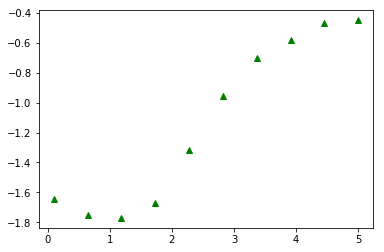

In [24]:
avg_energy = np.sum(energies, axis=0) / num_average
print(avg_energy)

# energies = metropolis_sim(N, J, Ts, num_mc_trials)

# out_file = open("energies_metropolis.out", "w")
# for t, e in zip(Ts, energies):
#     out_file.write("{} {}\n".format(t, e))
# out_file.close()

plt.plot(Ts, avg_energy, linestyle="None", marker="^", color="green")

In [ ]:
# Wolff simulation
N = 30
J = 1
Ts = np.linspace(0.01, 5, 200)
num_mc_trials = 20000

energies = wolff_sim(N, J, Ts, num_mc_trials)

out_file = open("energies_wolff_new.out", "w")
for t, e in zip(Ts, energies):
    out_file.write("{} {}\n".format(t, e))
out_file.close()

# plt.plot(Ts, energies, linestyle="None", marker="^", color="green")

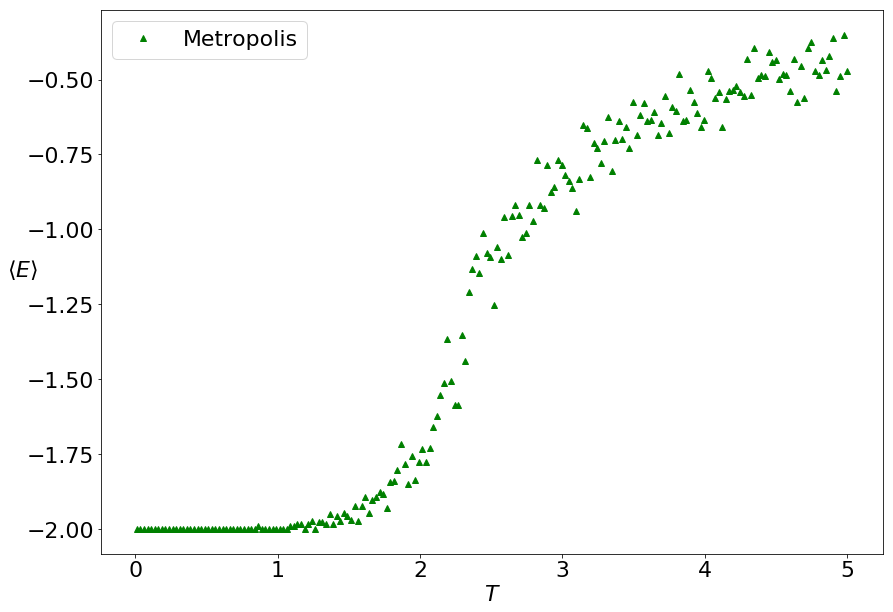

In [36]:
Ts = []
energies = []
with open("energies_metropolis.out", 'r') as in_file:
    lines = in_file.readlines()
    for l in lines:
        Ts.append(float(l.split()[0]))
        energies.append(float(l.split()[1]))
        
f, ax = plt.subplots(figsize=(14, 10))
rcParams['font.size'] = 22

ax.plot(Ts, energies, linestyle="None", marker="^", color="green", label='Metropolis')
ax.set_ylabel(r"$\langle E \rangle$", rotation=0)
ax.set_xlabel(r"$T$")

plt.legend()
plt.show()

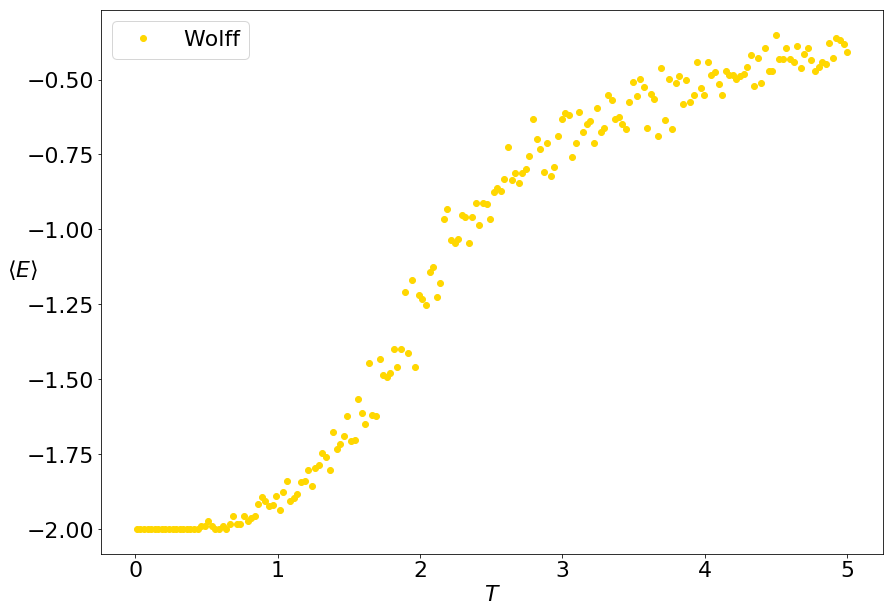

In [35]:
Ts = []
energies = []
with open("energies_wolff.out", 'r') as in_file:
    lines = in_file.readlines()
    for l in lines:
        Ts.append(float(l.split()[0]))
        energies.append(float(l.split()[1]))
        
f, ax = plt.subplots(figsize=(14, 10))
rcParams['font.size'] = 22

ax.plot(Ts, energies, linestyle="None", marker="o", color="gold", label='Wolff')
ax.set_ylabel(r"$\langle E \rangle$", rotation=0)
ax.set_xlabel(r"$T$")

plt.legend()
plt.show()

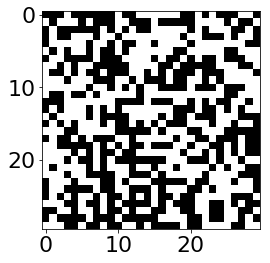

In [37]:
lattice = Lattice(30, 30)
plt.imshow(lattice.get_lattice(), cmap='binary')

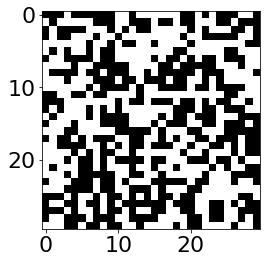

In [38]:
metropolis(lattice, 1, 1, 100)
plt.imshow(lattice.get_lattice(), cmap='binary')

(array([  7.,   8.,  10.,  24.,  29.,  15.,   5.,   1.,   0.,   1.]),
 array([-1648., -1600., -1552., -1504., -1456., -1408., -1360., -1312.,
        -1264., -1216., -1168.]),
 <a list of 10 Patch objects>)

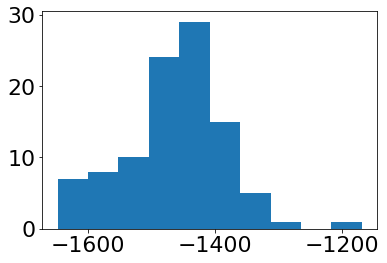

In [60]:
energies = []
for n in range(100):
    lattice = Lattice(30, 30)
    metropolis(lattice, 1, 1, 1000)
    energies.append(compute_H(lattice, 1))
#     plt.imshow(lattice.get_lattice(), cmap='binary')
plt.hist(energies)

(array([  2.,   3.,  12.,  23.,  21.,  14.,  22.,   2.,   0.,   1.]),
 array([-3176. , -3125.6, -3075.2, -3024.8, -2974.4, -2924. , -2873.6,
        -2823.2, -2772.8, -2722.4, -2672. ]),
 <a list of 10 Patch objects>)

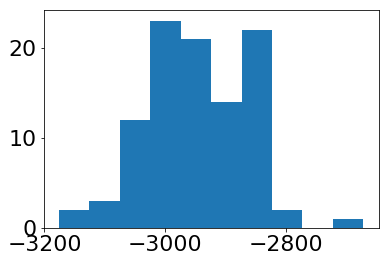

In [61]:
energies = []
for n in range(100):
    lattice = Lattice(30, 30)
    metropolis(lattice, 1, 1, 10000)
    energies.append(compute_H(lattice, 1))
#     plt.imshow(lattice.get_lattice(), cmap='binary')
plt.hist(energies)

(array([ 43.,   0.,   3.,   8.,  12.,  12.,  20.,   1.,   0.,   1.]),
 array([-3600. , -3550.4, -3500.8, -3451.2, -3401.6, -3352. , -3302.4,
        -3252.8, -3203.2, -3153.6, -3104. ]),
 <a list of 10 Patch objects>)

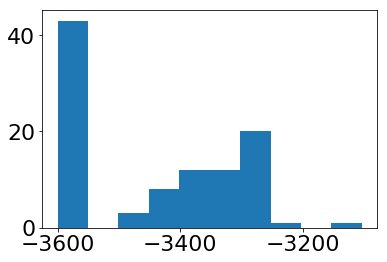

In [62]:
energies = []
for n in range(100):
    lattice = Lattice(30, 30)
    metropolis(lattice, 1, 1, 100000)
    energies.append(compute_H(lattice, 1))
#     plt.imshow(lattice.get_lattice(), cmap='binary')
plt.hist(energies)

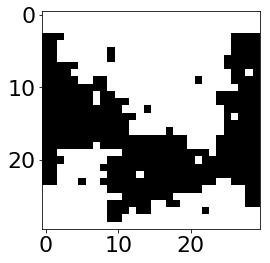

In [77]:
lattice = Lattice(30, 30)
metropolis(lattice, 1, 0.5, 100000)
plt.imshow(lattice.get_lattice(), cmap='binary')

(array([ 1.,  1.,  0.,  0.,  0.,  3.,  1.,  0.,  2.,  2.]),
 array([-1.76888889, -1.75955556, -1.75022222, -1.74088889, -1.73155556,
        -1.72222222, -1.71288889, -1.70355556, -1.69422222, -1.68488889,
        -1.67555556]),
 <a list of 10 Patch objects>)

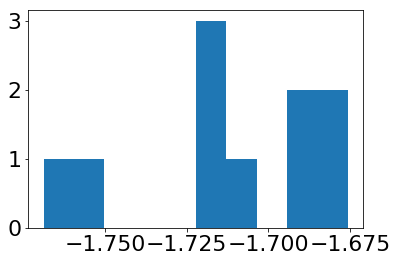

In [82]:
energies = []
for n in range(10):
    lattice = Lattice(30, 30)
    metropolis(lattice, 1, 0.5, 1000000)
    energies.append(compute_H(lattice, 1) / (2 * 30**2))
#     plt.imshow(lattice.get_lattice(), cmap='binary')
plt.hist(energies)

In [96]:
lattice = Lattice(30, 30)
metropolis(lattice, 1, 0.5, 1000000)

In [98]:
lattice = np.random.choice([-1, 1], size=(30, 30))

In [120]:
lattice = Lattice(30, 30)
%timeit metropolis(lattice, 1, 1, 1)

11.3 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [115]:
%%cython
import math
import numpy as np
def metropolis_c(lattice, J, beta, num_trials):
    size_x, size_y = lattice.get_size()
    for n in range(num_trials):
        i, j = int(np.random.uniform(0, size_x)), int(np.random.uniform(0, size_y))

        H_mol = 0
        neighbor_spins, neighbor_locations = lattice.get_neighbors(i, j)
        for neighbor in neighbor_spins:
            H_mol += J * neighbor

        delta_E = 2 * lattice.get(i, j) * H_mol

        if np.random.uniform() < math.exp(-beta * delta_E):
            lattice.flip(i, j)

In [121]:
lattice = Lattice(30, 30)
%timeit metropolis_c(lattice, 1, 1, 1)

10.6 µs ± 578 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


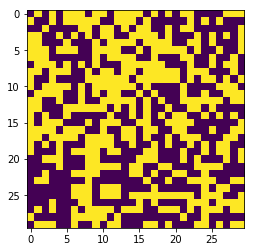

In [72]:
lattice = Lattice(30, 30)
plt.imshow(lattice.get_lattice())
thermalize(lattice, 1, 0.5, 'metropolis')

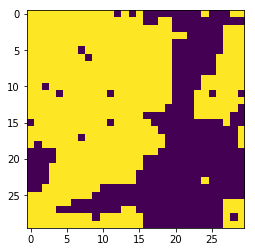

In [73]:
plt.imshow(lattice.get_lattice())

In [41]:
lattice = Lattice(30, 30)
energies = metropolis_sim_sweep(lattice, 0.5, 1)

(array([  6.,   8.,  18.,  24.,  16.,  14.,   7.,   5.,   1.,   1.]),
 array([-0.93111111, -0.91555556, -0.9       , -0.88444444, -0.86888889,
        -0.85333333, -0.83777778, -0.82222222, -0.80666667, -0.79111111,
        -0.77555556]),
 <a list of 10 Patch objects>)

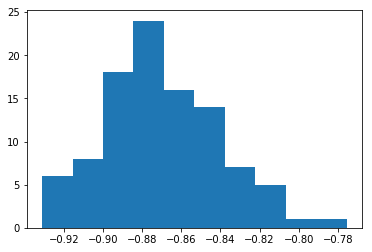

In [42]:
plt.hist(energies)

In [34]:
compute_H(lattice, 1)

-1.9911111111111111

In [59]:
lattice = Lattice(30, 30)
energies = wolff_sim_sweep(lattice, 1, 1)

(array([ 3.,  0.,  0.,  3.,  0.,  1.,  0.,  1.,  0.,  2.]),
 array([-1.92888889, -1.92133333, -1.91377778, -1.90622222, -1.89866667,
        -1.89111111, -1.88355556, -1.876     , -1.86844444, -1.86088889,
        -1.85333333]),
 <a list of 10 Patch objects>)

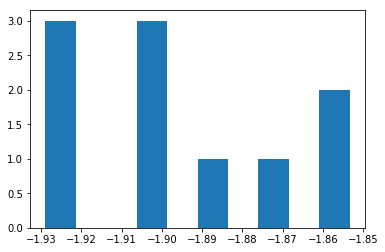

In [60]:
plt.hist(energies)

In [129]:
# metropolis simulation
N = 30
J = 1
Ts = np.linspace(2, 3, 10)

energies = []

for T in Ts:
    beta = 1 / T
    energies.append(metropolis_sim_sweep(N, J, beta))
    
with open("metropolis_t_e_c_sweep.out", "w") as out_file:
    avg_e = [np.average(e) for e in energies]
    avg_e2 = [np.average(np.asarray(e)**2) for e in energies]
    std_e = [np.std(e)**2 for e in energies]    
    
    for T, e, e2, s in zip(Ts, avg_e, avg_e2, std_e):
        beta = 1 / T
        C = s / N**2
        out_file.write("{} {} {}\n".format(T, e / N**2, C))

KeyboardInterrupt: 

In [86]:
[np.average(e) for e in energies]

[-0.19955555555555557, -2.0]

In [87]:
[np.average(np.asarray(e)**2) for e in energies]

[0.041866666666666677, 4.0]

In [88]:
[np.average(np.asarray(e)**2) - np.average(e)**2 for e in energies]

[0.0020442469135802527, 0.0]

In [90]:
# metropolis simulation
N = 30
J = 1
Ts = np.linspace(0.1, 5, 2)

energies = []

for T in Ts:
    energies.append(wolff_sim_sweep(N, J, T))

KeyboardInterrupt: 

In [19]:
lattice = Lattice(10, 10)
lattice.print()
compute_H(lattice, 1)

[[ 1  1 -1 -1  1  1  1 -1  1  1]
 [-1  1 -1  1 -1 -1  1  1  1  1]
 [-1  1  1 -1  1  1  1  1 -1  1]
 [ 1 -1  1  1  1 -1  1  1 -1 -1]
 [ 1  1 -1  1  1 -1 -1  1  1 -1]
 [-1 -1 -1  1  1  1  1  1 -1  1]
 [ 1 -1  1  1  1  1  1  1  1  1]
 [-1  1  1  1 -1  1  1  1  1  1]
 [ 1  1  1  1 -1 -1  1  1  1  1]
 [ 1  1  1  1  1 -1 -1  1 -1  1]]


-28.0

In [22]:
(-1) % 10

9

In [24]:
lattice = Lattice(10, 10)
%timeit thermalize(lattice, 1, 1, 'metropolis')

14.6 s ± 1.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


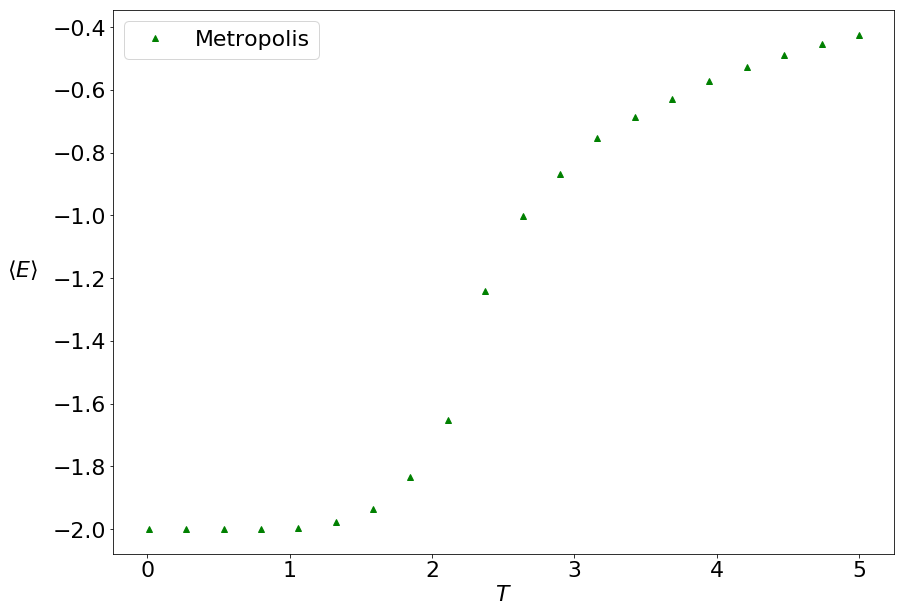

In [37]:
Ts = []
energies = []
Cs = []
acceptances = []

with open("metropolis_sweep_c.txt", 'r') as in_file:
    lines = in_file.readlines()
    for l in lines:
        Ts.append(float(l.split()[0]))
        energies.append(float(l.split()[1]))
        Cs.append(float(l.split()[2]))
        acceptances.append(float(l.split()[3]))
        
f, ax = plt.subplots(figsize=(14, 10))
rcParams['font.size'] = 22

ax.plot(Ts, energies, linestyle="None", marker="^", color="green", label='Metropolis')
ax.set_ylabel(r"$\langle E \rangle$", rotation=0, labelpad=30)
ax.set_xlabel(r"$T$")

plt.legend()
plt.show()

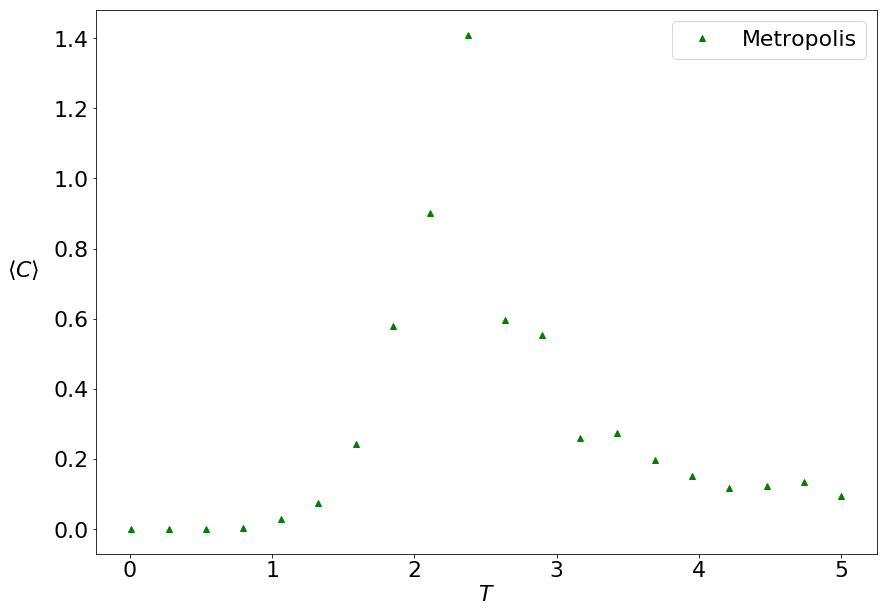

In [36]:
f, ax = plt.subplots(figsize=(14, 10))
rcParams['font.size'] = 22

ax.plot(Ts, Cs, linestyle="None", marker="^", color="green", label='Metropolis')
ax.set_ylabel(r"$\langle C \rangle$", rotation=0, labelpad=30)
ax.set_xlabel(r"$T$")

plt.legend()
plt.show()

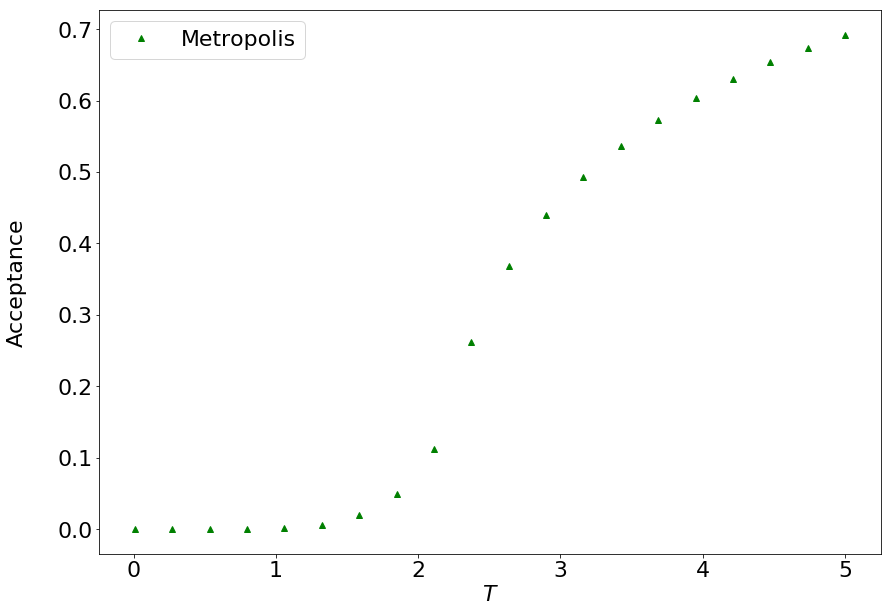

In [39]:
f, ax = plt.subplots(figsize=(14, 10))
rcParams['font.size'] = 22

ax.plot(Ts, acceptances, linestyle="None", marker="^", color="green", label='Metropolis')
ax.set_ylabel("Acceptance", labelpad=30)
ax.set_xlabel(r"$T$")

plt.legend()
plt.show()

In [46]:
Ts = []
energies = []
Cs = []

with open("wolff_sweep_c.txt", 'r') as in_file:
    lines = in_file.readlines()
    for l in lines:
        Ts.append(float(l.split()[0]))
        energies.append(float(l.split()[1]))
        Cs.append(float(l.split()[2]))

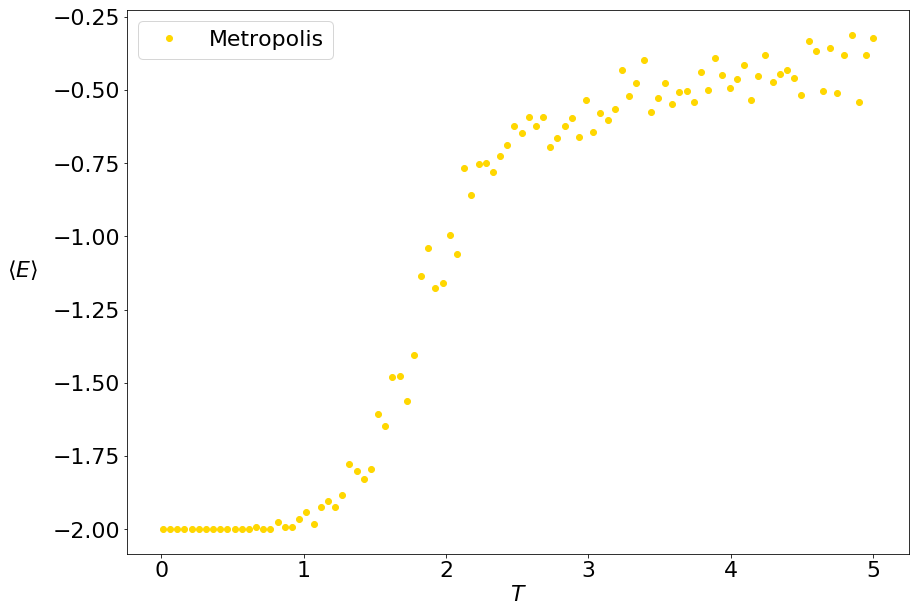

In [47]:
f, ax = plt.subplots(figsize=(14, 10))
rcParams['font.size'] = 22

ax.plot(Ts, energies, linestyle="None", marker="o", color="gold", label='Metropolis')
ax.set_ylabel(r"$\langle E \rangle$", rotation=0, labelpad=30)
ax.set_xlabel(r"$T$")

plt.legend()
plt.show()

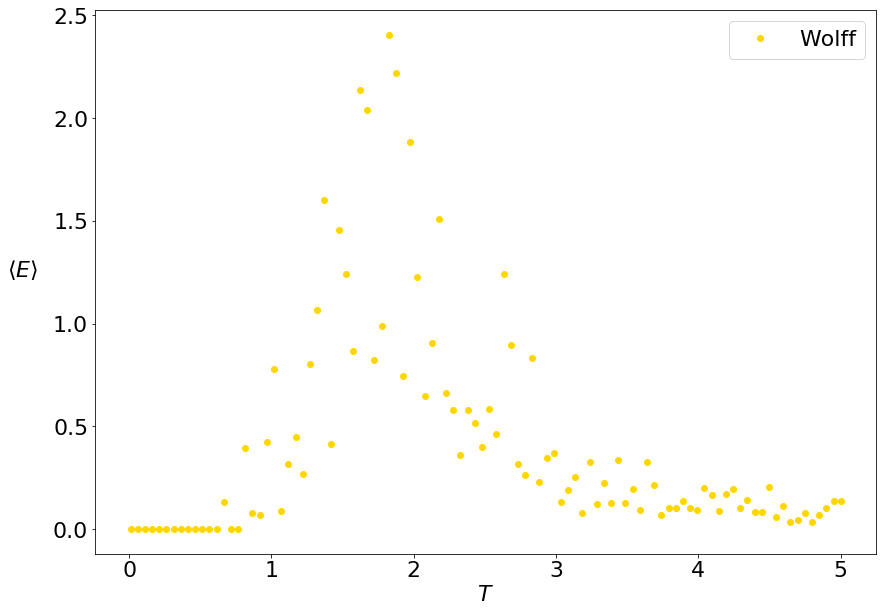

In [49]:
f, ax = plt.subplots(figsize=(14, 10))
rcParams['font.size'] = 22

ax.plot(Ts, Cs, linestyle="None", marker="o", color="gold", label='Wolff')
ax.set_ylabel(r"$\langle E \rangle$", rotation=0, labelpad=30)
ax.set_xlabel(r"$T$")

plt.legend()
plt.show()